In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import edward as ed
from edward.models import Normal, MultivariateNormalDiag
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp
from sem import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerNN, KerasSRN

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


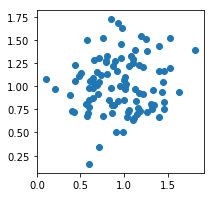

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

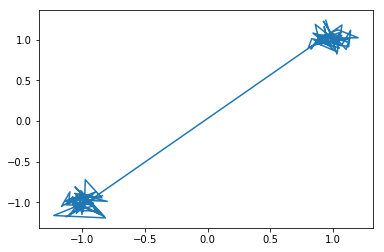

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 100  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def plot_segmentation(post):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
        
    axes[1].plot(post)
    
    print np.argmax(post, axis=1)

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


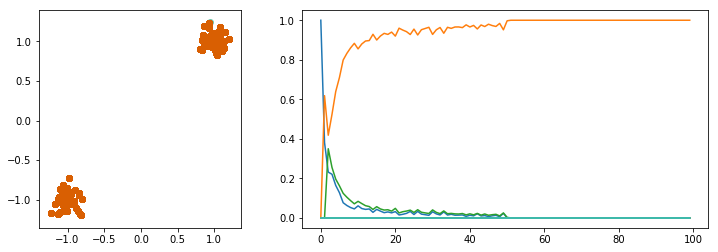

In [6]:
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 14 15 16 17 15 18 19  8 15 14
 18 10 11 11 11 11 11 11 15 15  4  8 12 12 12 12 12 12 12  7 15 15 10 10  0
 11 13 10  9  6  9 10  9  9  9  2  2 13  9 17 16 16 16 19 18 14  8  8 12 14
 14  3 17 17 17 18  9 13 13 10 10 13 17 17  1  9  9  9  9  9  9  9  9  9 10]


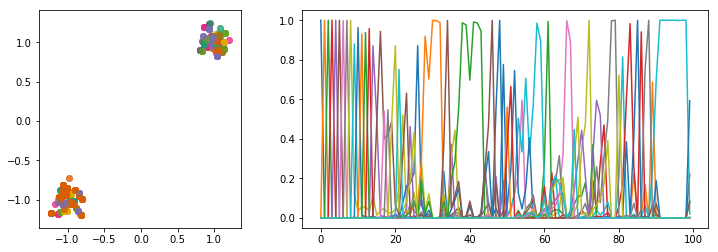

In [7]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2 = SEM(**sem_kwargs)
post = sem2.run(x_train, K=K)
plot_segmentation(post)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


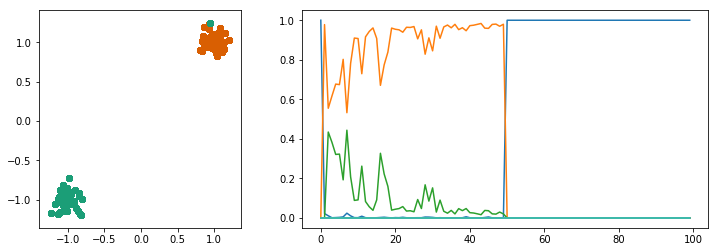

In [8]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerNN, f_opts=dict())

sem3 = SEM(**sem_kwargs)
post = sem3.run(x_train, K=K)
plot_segmentation(post)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 3 4 5 6 7
 7 7 5 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


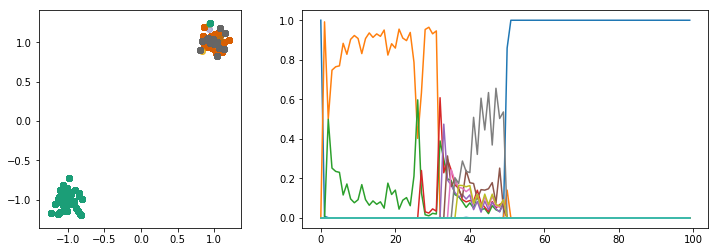

In [9]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasSRN, f_opts=dict(t=5))

sem4 = SEM(**sem_kwargs)
post = sem4.run(x_train, K=K)
plot_segmentation(post)

# Alternating between 2 static events


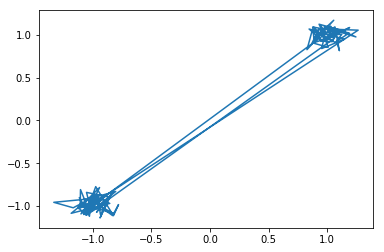

In [10]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


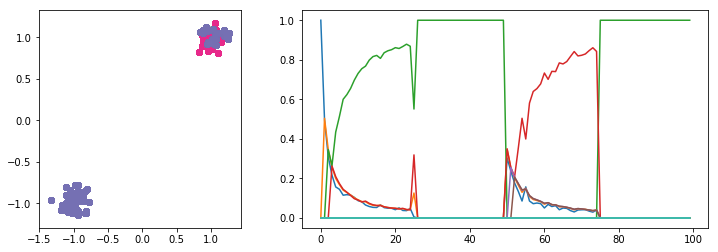

In [11]:
post = sem.run(x_train, K=K)
plot_segmentation(post)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 11 16 17 18 19  2 14  0  1
 11  7 18  7  7  7 19 19 19 19 14 19 19 19 19 19 19 17 17 17 19 19 19 17  8
 11 17 13 12 14 13 11  1  4  4  4  4  6  2  2  9 10 10 12 15 15 15 15 10 10
 11 12 17 15 14 14 14 14 14 14 14  9  4 11  5 19 19 19 19  5  5  5  2  2  2]


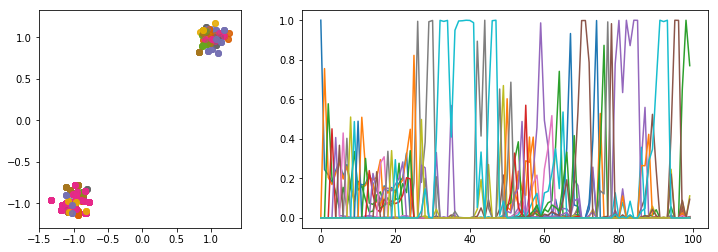

In [12]:
post = sem2.run(x_train, K=K)
plot_segmentation(post)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


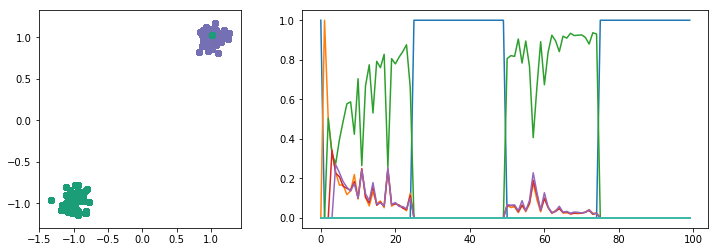

In [13]:
post = sem3.run(x_train, K=K)
plot_segmentation(post)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



[ 0  1  2  3  4  5  4  6  4  3  3  7  3  3  3  3  3  8  9  7  7  7  7  7  7
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7 10 11  7  7  7
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  0  0  0  0  0  0  0  0  0  0  0]


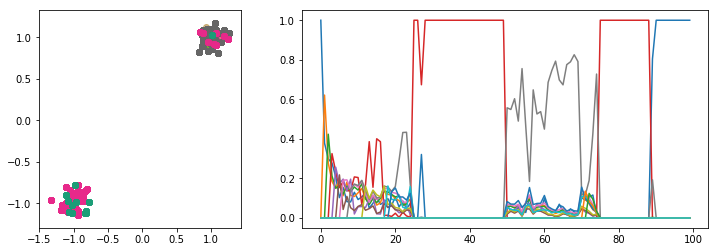

In [14]:
post = sem4.run(x_train, K=K)
plot_segmentation(post)

# Example of four events where the events correspond to movement in vector space

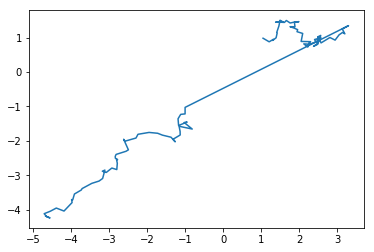

In [15]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


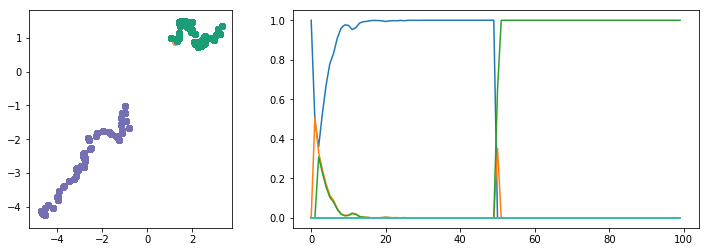

In [16]:
post = sem.run(x_train, K=K)
plot_segmentation(post)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  1 16 16 17 18 19 19 18  2
  2  2  8 17 11 15 15 19 13 13 13 13 13 13  9  9 19 19 19 19 19  6  6  6  6
 15  0 18 18 18 18 18 15 17 17 19 19 18 11 17 15 15  0  7  4  4  4  4  0  0
  0  0  5  5  5 16 13  2  2  2  2  2  1 10 10 10 10 10 10 10 10 10 10 10 10]


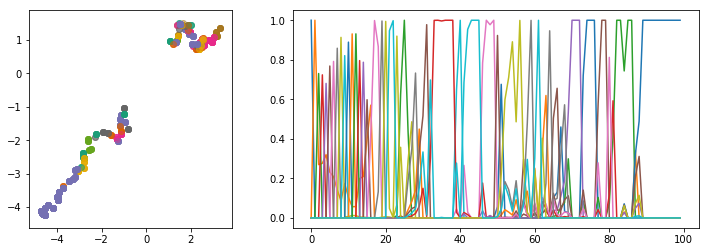

In [17]:
post = sem2.run(x_train, K=K)
plot_segmentation(post)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


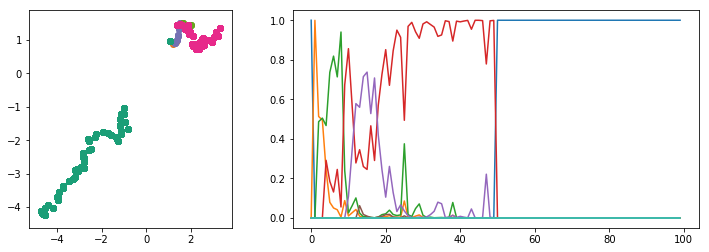

In [18]:
post = sem3.run(x_train, K=K)
plot_segmentation(post)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


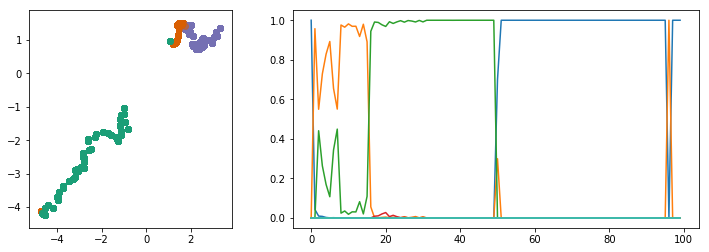

In [19]:
post = sem4.run(x_train, K=K)
plot_segmentation(post)

# 4 events where the events correspond to movement in vector space


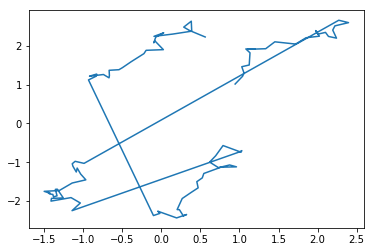

In [20]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


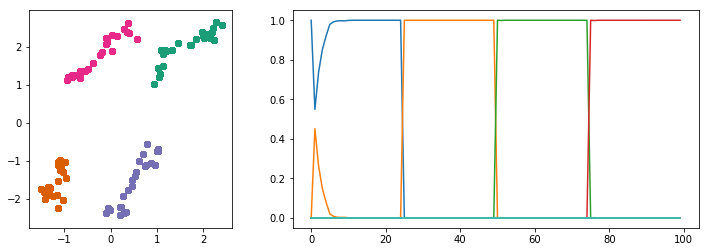

In [21]:
post = sem.run(x_train, K=K)
plot_segmentation(post)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 14 15 15 16 17 18 18 19 14  5
  0  0  0 10  0  0  6  6  6  0  3 10 10 16 11  7  7  7  7  7  7  7  7  7  7
 10 10 14 14 14 14  2 12 18  6  6  6  6 10  6  6  7  7  7  7  7  7  7  7  7
 14 12  0  0  8  5 11 11  1  1 15 15 10 19 18 16 12 12 12 12 17 13 13  8  8]


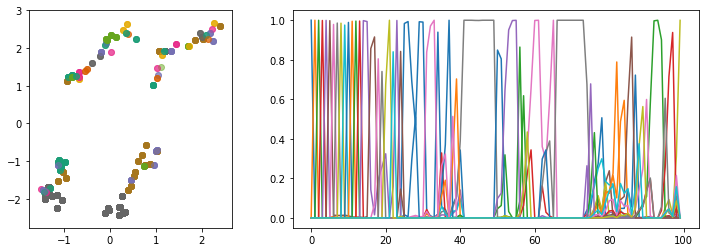

In [22]:
post = sem2.run(x_train, K=K)
plot_segmentation(post)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]


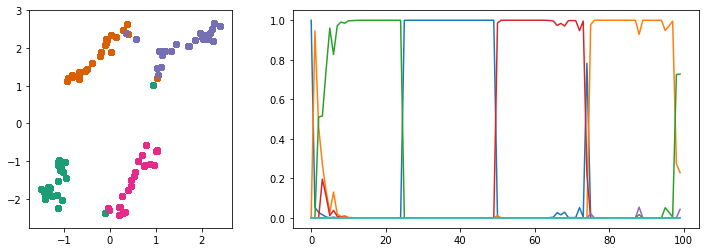

In [23]:
post = sem3.run(x_train, K=K)
plot_segmentation(post)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 1 1 1]


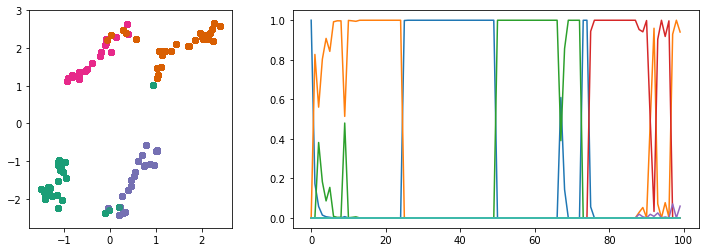

In [24]:
post = sem4.run(x_train, K=K)
plot_segmentation(post)

# 

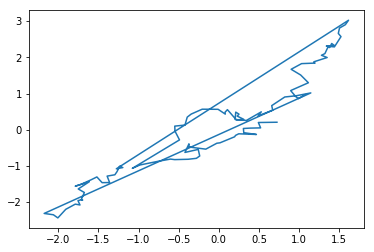

In [25]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


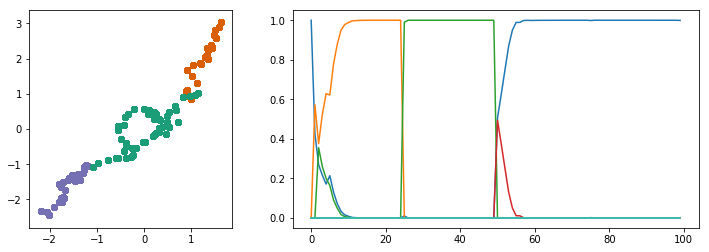

In [26]:
post = sem.run(x_train, K=K)
plot_segmentation(post)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



[ 0  1  2  3  4  5  6  6  6  7  8  8  9 10 11 12 12 13 13 14 15 16 17 18 19
 12 10  0 12  0 12 12 12 12  6  6 13 13 13  7  7 17 17  0  0  0  0  0  0  0
 17 12  9 13 12  8  4 16 15 12  1 12 12 12  8  8  8 17 17 12 12 12 13 13  0
  1  1  0  0 15 15  4  9  9  9  9  0  0  0  1 10 10  3  7  3  3 12 12 18  4]


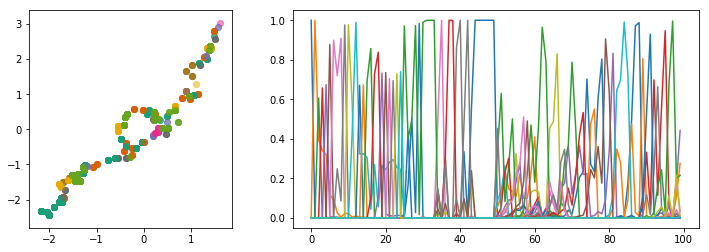

In [27]:
post = sem2.run(x_train, K=K)
plot_segmentation(post)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 2 2 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


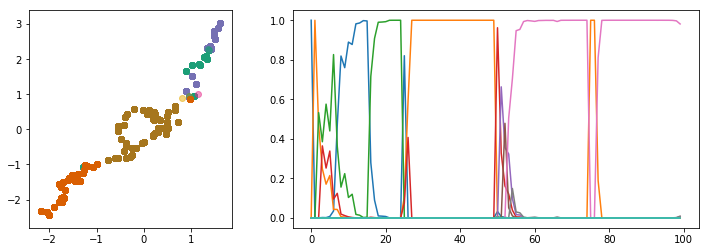

In [28]:
post = sem3.run(x_train, K=K)
plot_segmentation(post)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



[0 1 2 3 4 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0]


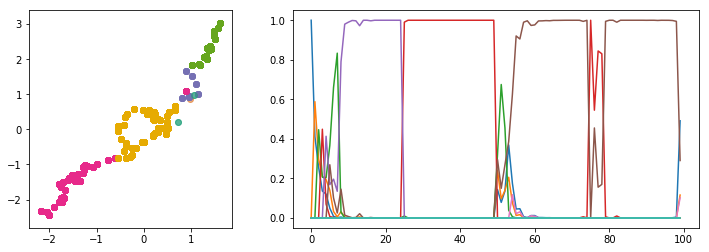

In [29]:
post = sem4.run(x_train, K=K)
plot_segmentation(post)